<a href="https://colab.research.google.com/github/satoshi19989/transformer_practice/blob/main/transformer_time_series2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [4]:
!git clone https://github.com/satoshi19989/transformer_practice.git

Cloning into 'transformer_practice'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 59 (delta 32), reused 32 (delta 13), pack-reused 0
Unpacking objects: 100% (59/59), 449.24 KiB | 2.42 MiB/s, done.


In [5]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [6]:
module_path = "/content/transformer_practice/modules"
sys.path.append(module_path)

# 対象データ確認

In [7]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-26 22:17:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.166.32, 52.217.110.158, 3.5.2.15, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.166.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  55.3MB/s    in 0.2s    

2023-02-26 22:17:13 (55.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [8]:
#例１

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(header))
print(len(lines))


#例2

# data_path = os.path.join(module_path, "influenza_transformer/data")
# data = pd.read_csv(os.path.join(data_path, "dfs_merged_upload.csv"), index_col=0)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420451


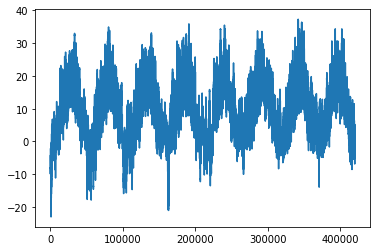

In [9]:
from matplotlib import pyplot as plt

#例1
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

plt.plot(range(len(temperature)), temperature)


# for i, seq in enumerate(raw_data.T):
#   plt.figure()
#   plt.plot(seq)
#   plt.title(header[i+1])

#例2
# plt.figure()
# plt.plot(data['FCR_N_PriceEUR'])

In [18]:
type(raw_data)

numpy.ndarray

# 学習用データ生成

In [10]:
from generate_data import PreprocessData

# sampling_rate = 6
# sequence_length = 120
# pred_points = 10
# delay = sampling_rate * (sequence_length + 24 - 1)
# batch_size = 256

sampling_rate = 1
sequence_length = 120
pred_points = 10
delay = sampling_rate * (sequence_length )
batch_size = 256

dg = PreprocessData(raw_data, 
                      temperature, 
                      sequence_length, 
                      delay, 
                      batch_size, 
                      sampling_rate)

train_dataset_single, val_dataset_single, test_dataset_single = dg.generate_dataset_single()
train_dataset, val_dataset, test_dataset = dg.generate_dataset_multistep(pred_points)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


/content/transformer_practice/modules/generate_data.py:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tar_temp = np.array(tar_temp)


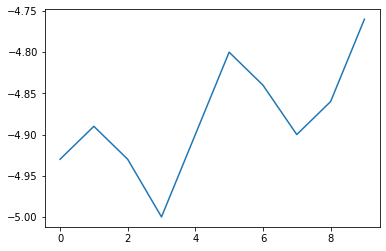

In [13]:
plt.figure()
plt.plot(temperature[delay:delay+10])

(256, 129, 14) => (256, 10)
(256, 10, 14) (256, 10)


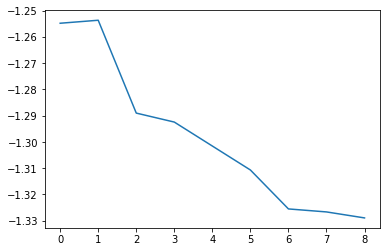

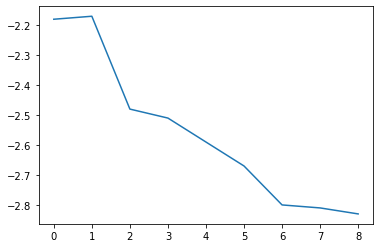

In [14]:
for x,y in train_dataset:
    #x, y = train_dataset[i]
    print('%s => %s' % (x.shape, y.shape))
    enc_input = x[:,:sequence_length]
    dec_input = x[:,sequence_length-1:]
    print(dec_input.shape, y.shape)

    plt.figure()
    plt.plot(dec_input[0,1:,1])

    plt.figure()
    plt.plot(y[0,:-1])
    break

In [12]:
def evaluate_naive_method(dataset, mean, std):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset_single, dg.mean, dg.std):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset_single, dg.mean, dg.std):.2f}")

Validation MAE: 0.15
Test MAE: 0.16


# 基本的なNNを試す

In [ ]:
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers

class MyLayer(tf.keras.layers.Layer):
  def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
      super().__init__(trainable, name, dtype, dynamic, **kwargs)

      self.flat = layers.Flatten()
      self.layer1 = layers.Dense(16, activation="relu")
      self.layer2 = layers.Dense(1)

  def call(self, x):
    print(x.shape)
    x = self.flat(x)
    x = self.layer1(x)
    x = self.layer2(x)
    return x

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
outputs = MyLayer()(inputs)
model = keras.Model(inputs, outputs)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# history = model.fit(x_train, 
#                     y_train, 
#                     epochs=10,
#                     #batch_size=batch_size, 
#                     validation_data=(x_val, y_val),
#                     callbacks=callbacks)

history = model.fit(train_dataset, 
                    epochs=10,
                    batch_size=batch_size, 
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras", custom_objects={'MyLayer':MyLayer})

print(f"Test MAE: {model.evaluate(x_test, y_test)[1]:.2f}")

(None, 120, 14)
Epoch 1/10
(None, 120, 14)
(None, 120, 14)
819/819 [==============================] - 58s 69ms/step - loss: 11.8802 - mae: 2.6696 - val_loss: 10.9544 - val_mae: 2.6091
Epoch 2/10
819/819 [==============================] - 56s 69ms/step - loss: 8.7167 - mae: 2.3203 - val_loss: 10.5987 - val_mae: 2.5671
Epoch 3/10
819/819 [==============================] - 58s 70ms/step - loss: 8.0300 - mae: 2.2254 - val_loss: 10.7199 - val_mae: 2.5914
Epoch 4/10
819/819 [==============================] - 55s 67ms/step - loss: 7.6188 - mae: 2.1682 - val_loss: 11.3213 - val_mae: 2.6626
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 7.3211 - mae: 2.1259 - val_loss: 11.3968 - val_mae: 2.6609
Epoch 6/10
819/819 [==============================] - 57s 70ms/step - loss: 7.1142 - mae: 2.0958 - val_loss: 10.4062 - val_mae: 2.5446
Epoch 7/10
819/819 [==============================] - 58s 70ms/step - loss: 6.9464 - mae: 2.0699 - val_loss: 10.9125 - val_mae: 2.6128
Epoch 

ValueError: ignored

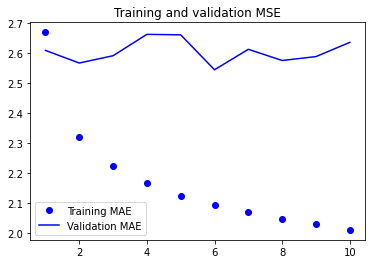

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MSE")
plt.legend()
plt.show()

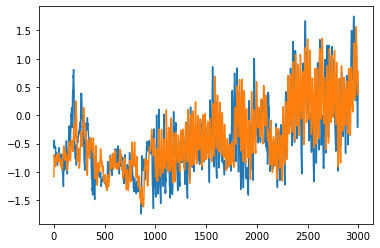

In [ ]:
end_point = 3000

plt.figure()
plt.plot(y_test[:end_point])
plt.plot(y_pred[:end_point,0])

In [ ]:
MSE, r2 = utility.calc_score(y_test, y_pred[:,0])
print("MSE : ", MSE)
print("r2 : ", r2)

MSE :  0.38244757104208854
r2 :  0.8241300222865205


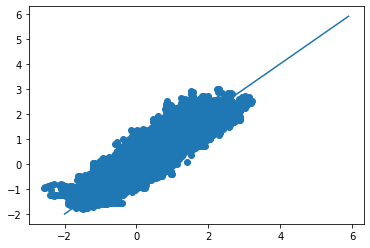

In [ ]:
x = np.arange(-2, 6, 0.1)
y = x

plt.figure()
plt.scatter(y_test, y_pred[:,0])
plt.plot(x, y)

# トランスフォーマの構築

In [11]:
dmodel = 28

In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from transformer_layers import Encoder, TransformerDecoder
import transformer_core as tfc
from transformer_core import TransformerBaseTimeSeriesForecastModel, EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)


# inputs = keras.Input(shape=(None,))
# x = Encoder(4, dmodel, 1, 100, sequence_length, 20000, 0.2)(x, True, None)  # (batch_size, inp_seq_len, d_model)
# outputs = layers.Dense(1)(x)

# model = keras.Model(inputs, outputs)





#inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
inputs = keras.Input(shape=(sequence_length+pred_points -1, raw_data.shape[-1]))

# outputs = EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel(num_layers=1, # Multi-head Attentionの繰り返し数
#                                                   d_model = dmodel, # embeddingの次元
#                                                   num_heads=1,  # Multi-head Attentionのヘッド数
#                                                   dff = 30,      #全結合層のユニット数
#                                                   pe_input = sequence_length, 
#                                                   window_width = sequence_length, 
#                                                   rate=0.2)(inputs)
                                 
outputs = TransformerBaseTimeSeriesForecastModel(num_layers=2, # Multi-head Attentionの繰り返し数
                                                  d_model = dmodel, # embeddingの次元
                                                  num_heads=2,  # Multi-head Attentionのヘッド数
                                                  dff = 30,      #全結合層のユニット数
                                                  pe_input = sequence_length, 
                                                  pe_target = pred_points,
                                                  window_width = sequence_length, 
                                                  rate=0.2)(inputs)

model = keras.Model(inputs, outputs)


#model.build(input_shape=(batch_size, sequence_length, 14))
model.compile(loss=criterion, optimizer=optimizer, metrics=['mae'])




In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 14)]         0         
                                                                 
 transformer_base_time_serie  (None, 10, 1)            34141     
 s_forecast_model (Transform                                     
 erBaseTimeSeriesForecastMod                                     
 el)                                                             
                                                                 
Total params: 34,141
Trainable params: 34,141
Non-trainable params: 0
_________________________________________________________________


In [38]:
import shutil

# input = tf.concat([enc_train, dec_train], axis=1)
# val_input = tf.concat([enc_val, dec_val], axis=1)
# val_data = (val_input, y_val)

# print(val_input.shape, y_val.shape)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.dirname('/content/models/cp.ckpt'),
                                                 save_weights_only=True,
                                                 verbose=1)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    lr_decay
    , cp_callback
]
#history=model.fit(input, y_train, batch_size=batch_size, epochs=10, validation_data=val_data, callbacks=callbacks,verbose=2)
history=model.fit(train_dataset, batch_size=batch_size, epochs=10, validation_data=val_dataset, callbacks=callbacks,verbose=2)
# model = keras.models.load_model("jena_dense.keras", 
#                                 custom_objects={"EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel":EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel})

shutil.move("models.index", "/content/drive/MyDrive/models/models.index")
shutil.move("models.data-00000-of-00001", "/content/drive/MyDrive/models/models.data-00000-of-00001")
shutil.move("checkpoint", "/content/drive/MyDrive/models/checkpoint")

Epoch 1/10

Epoch 1: saving model to /content/models
821/821 - 789s - loss: 152.6103 - mae: 10.4555 - val_loss: 161.3294 - val_mae: 10.9211 - lr: 0.0000e+00 - 789s/epoch - 961ms/step
Epoch 2/10

Epoch 2: saving model to /content/models
821/821 - 802s - loss: 90.4888 - mae: 7.5390 - val_loss: 56.3272 - val_mae: 5.5109 - lr: 1.4967e-05 - 802s/epoch - 976ms/step
Epoch 3/10

Epoch 3: saving model to /content/models
821/821 - 802s - loss: 49.0272 - mae: 4.9668 - val_loss: 42.1071 - val_mae: 4.3892 - lr: 2.9933e-05 - 802s/epoch - 977ms/step
Epoch 4/10

Epoch 4: saving model to /content/models
821/821 - 809s - loss: 35.5093 - mae: 3.8962 - val_loss: 29.7337 - val_mae: 3.3757 - lr: 4.4900e-05 - 809s/epoch - 985ms/step
Epoch 5/10

Epoch 5: saving model to /content/models
821/821 - 787s - loss: 22.9876 - mae: 2.9091 - val_loss: 17.2106 - val_mae: 2.2928 - lr: 5.9867e-05 - 787s/epoch - 959ms/step
Epoch 6/10

Epoch 6: saving model to /content/models
821/821 - 821s - loss: 11.8867 - mae: 1.9162 - v

'/content/drive/MyDrive/models/checkpoint'

In [14]:
checkpoint_path = "/content/drive/MyDrive/models/models"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)

# Loads the weights
model.load_weights(checkpoint_path)

In [23]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

410/410 [==============================] - 160s 382ms/step - loss: 0.4122 - mae: 0.4551
Test MAE: 0.46


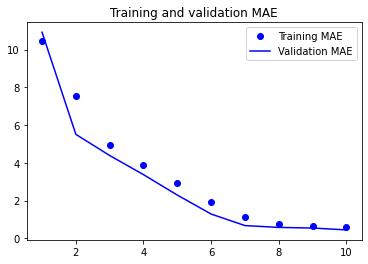

In [40]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

samples shape: (256, 129, 14)
targets value: (256, 10)
preds value: (256, 10, 1)


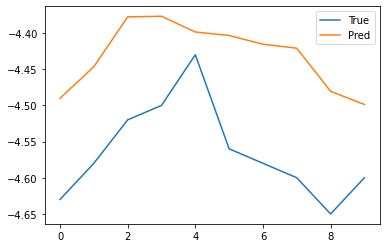

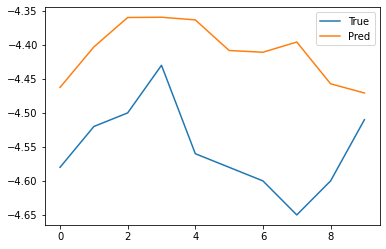

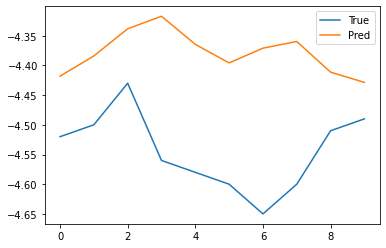

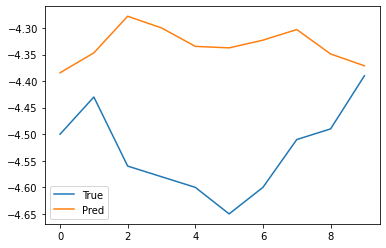

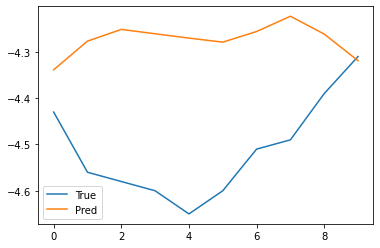

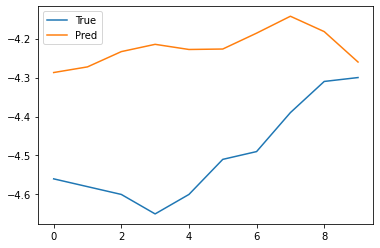

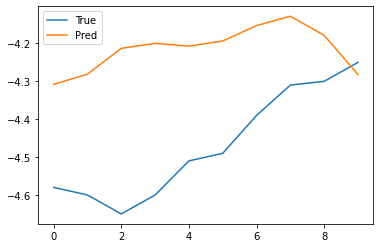

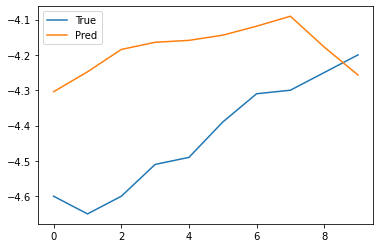

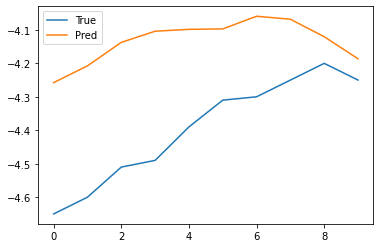

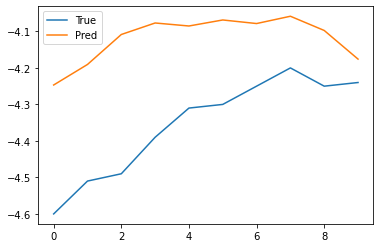

In [35]:
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets value:", targets.shape)
    
    targets_pred = model.predict(samples, verbose=0)
    print("preds value:", targets_pred.shape)  

    for i in range(10):
      plt.figure()
      plt.plot(targets[i], label="True")
      plt.plot(targets_pred[i,:,0], label="Pred")
      plt.legend()
      plt.show()

    break



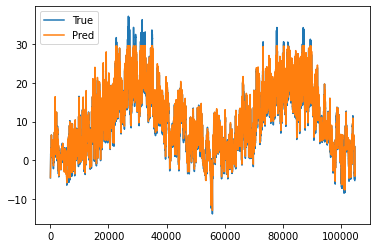

In [26]:
y_true = []
y_pred = []
for samples, targets in test_dataset:
    # print("samples shape:", samples.shape)
    # print("targets value:", targets.shape)
    
    targets_pred = model.predict(samples, verbose=0)
    #print("preds value:", targets_pred.shape)  

    for i in range(len(targets)):
      y_true.append(targets[i,-1])
      y_pred.append(targets_pred[i,-1,0])
    #break



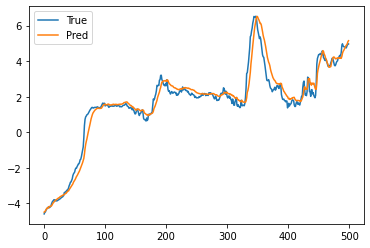

In [32]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

start_point = 0
end_point = 500

plt.figure()
plt.plot(y_true[start_point:end_point], label="True")
plt.plot(y_pred[start_point:end_point], label="Pred")
plt.legend()
plt.show()

In [ ]:

MSE, r2 = utility.calc_score(y_test[:,-1], y_pred[:,-1,0])
print(MSE, r2)

0.20853984289677904 0.9477040455568707


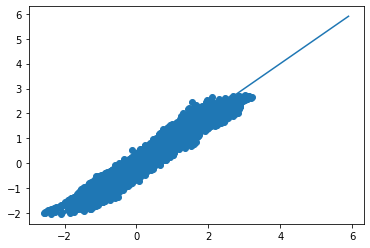

In [ ]:
x = np.arange(-2, 6, 0.1)
y = x

plt.figure()
plt.scatter(y_test[:,-1], y_pred[:,-1,0])
plt.plot(x, y)